# Constellation Learning in an AWGN Channel

In this notebook, we will learn how to implement an end-to-end digital communication system as an `AutoEncoder`[1] and compared its performance with a `(n,k) Hamming Code`.

 * We analyze the performance of an autoencoder based modeling of a communication system as opposed to                  traditional modeling, where designing signal alphabet at transmitter (Tx) and detection algorithms at    receiver    (Rx) are based on a given mathematical/statistical channel/system model.


 * We simulate the performance of an AutoEncoder based communication link in the presence of Additive White Gaussian    Noise (AWGN), where Tx sends one out of ``M`` message/information symbols per `n` channel uses through a noisy      channel and the Rx estimates the transmitted symbols through noisy observations.


* `The goal is to learn a signalling alphabet/constellation scheme that is robust with respect to the noise            introduced by the channel at Tx`



 ## Table of Contents

* [Importing Libraries](#import-libraries)
* [Parameters of AE](#AE-parameters)
* [Training Data](#training-data-set)
* [Testing Data](#testing-data-set)
* [Normalization Functions](#norm-func)
* [Defining AE Model](#AE-model)
* [Training AE](#AE-training)
* [Defining Tx, Channel and Rx from Trained AE](#individual-model)
* [Constellation Learning](#constellation-learning)
* [Block Error Rate (BLER) performance](#BLER)
* [References](#ref)



### PHY layer as AutoEncoder

* The fundamental idea behind this tutorial is to model Physical Layer as an ``AutoEncoder``(AE).


* An ``AutoEncoder``(AE) is an Artificial Neural Network (ANN) used to learn an efficient representation of data at   an intermediate layer to reproduce the input at its output.


* We Interpret end to end communication link, i.e., Tx, channel, and Rx as a single Neural Network (NN) that can be   trained as an AE which reconstructs its input at its output, as communication is all about                           reproducing/reconstructing messages transmitted by Tx at Rx faithfully in the presence of channel perturbations     and Rx noise.

### Steps

Following are the steps that we follow in simulation:

* Define the hyper parameters of AE :
    - number of information symbols `M`, where each symbol carry `k`bits
    
    - number of channel uses `n`
    
    - snr in dB at which AE is being trained, which we call `snr_train`
    
    
    
* Define embedings for each information symbol that is to be fed as an input to AE.


* Define training and testing data set by randomizing the label


* Define end to end AutoEncoder by using the already imported `keras` built in layers.

    - Tx is being implmented as a stack of two keras `Dense` layers one with `ReLU` activation and another with           `linear` activation. The output of the second Dense layer is fed to a normalization layer which we implement         using keras `Lambda` layer.
    
    - Channel is implemented as a single `Noise` layer with certain noise standard deviation, which is a function of       both Rate of the code (R) and snr_train.
    
    - Rx also consists of two keras Dense layers, one with `ReLU` activation and the last one with `softmax`               activation. The last layer must output probabilities (i.e., for a given received noisy vector **v** of               dimension M, it outputs max aposteriori probability vector of dimension M, i.e.,                                     max(prob(**w**|**v**)) for any **w** belongs to transmitted oneshot embeddings)

**Note:**  We choose different values of number of training (`N`) and testing samples (`N_test`) for constellation plots and for BlockErrorRate (BLER) plots.


**Note:** For `(n,k) = (7,4)`, we use `sklearn T-distributed Stochastic Neighbor Embedding (TSNE)` to plot the learned constellation. Typically we use less number of `N` and `N_test` in such cases.
For BLER plots we always go with high values of `N`, `N_test`   

![title](img/autoencoder.png)

## Importing Libraries

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Importing necessary Numpy, Matplotlib, TensorFlow, Keras and scikit-learn modules
# %matplotlib widget
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise, Lambda, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras import backend as be

In [ ]:
#!git clone https://github.com/GigayasaWireless/toolkit5G

In [ ]:
!git clone --branch website https://github.com/GigayasaWireless/toolkit5G.git


fatal: destination path 'toolkit5G' already exists and is not an empty directory.


In [ ]:
#!wget https://github.com/GigayasaWireless/toolkit5G/archive/refs/heads/website.zip -O toolkit5G.zip


--2024-10-28 07:43:41--  https://github.com/GigayasaWireless/toolkit5G/archive/refs/heads/website.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/GigayasaWireless/toolkit5G/zip/refs/heads/website [following]
--2024-10-28 07:43:41--  https://codeload.github.com/GigayasaWireless/toolkit5G/zip/refs/heads/website
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘toolkit5G.zip’

toolkit5G.zip           [               <=>  ] 267.64M  14.1MB/s    in 16s     

2024-10-28 07:43:58 (16.4 MB/s) - ‘toolkit5G.zip’ saved [280643619]



In [ ]:
!unzip toolkit5G.zip


Archive:  toolkit5G.zip
417f1ca5b87c5a70793e6976d42f00491301ade8
replace toolkit5G-website/.buildinfo? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
os.listdir()

['.config',
 'test_GettingStarted.html',
 'toolkit5G-website',
 'toolkit5G',
 'toolkit5G.zip',
 'sample_data']

In [ ]:
import sys
sys.path.append("/content/toolkit5G-website/api/5G_Toolkit/SymbolMapping")


In [ ]:
from toolkit5G.api.Toolkit import SymbolMapping as sm
from toolkit5G.api.Toolkit import ChannelCoder as cc

In [ ]:
print(os.listdir('/content/toolkit5G-website/api/5G_Toolkit/SymbolMapping'))

['symbolMapping.mapper.html', 'symbolMapping.demapper.html', 'symbolMapping.html']


In [ ]:
print(os.listdir('/content/toolkit5G-website/api/5G_Toolkit/ChannelCoder'))

['channelCoder.html', 'LDPC', 'ReedMullerCoder', 'HammingCoder', 'PolarCoder']


In [ ]:
sm.SymbolMapping.demapper
cc.ChannelCoder.HammingCoder

AttributeError: module 'toolkit5G.api.Toolkit.SymbolMapping' has no attribute 'SymbolMapping'

The following code cell defines the parametes of an AutoEncoder including the `snr_dB` at which it is being trained.
We assume (n,k) = (7,4) here but the code is generailized to support other configurations as well such as (2,4) and (2,2) given in [1]

## Parameters of AutoEncoder

In [ ]:
#################################################
# Parameters of a (n,k) AutoEncoder (AE)
# all the symbols are assumed to be real valued
#################################################

# number of information/message symbols that Tx communicates over channel to Rx
M = 16
# number of bits per information symbol
k = int(np.log2(M))
# number of channel uses or dimension of each code-word symbol or number of bits per code-word symbol
n = 7
# Rate of communication. i.e., k bits per n channel uses
R = k/n
print("###################################################################################################")
print("Parameters of "+str((n,k))+" AutoEncoder are:\n")
print("Number of Information Symbols:" + str(M))
print("Number of Bits Per Information Symbol:" + str(k))
print("Number of Channel Uses:" + str(n))
print("Rate of Communication:" + str(R))

###################################################################################################
Parameters of (7, 4) AutoEncoder are:

Number of Information Symbols:16
Number of Bits Per Information Symbol:4
Number of Channel Uses:7
Rate of Communication:0.5714285714285714


In [ ]:
###################################
#SNR at which AE is being trained
###################################
#---------------------------------------------------------------------------------------------------------------
# SNR in dB = Es/No, where Es: Energy per symbol, No: Noise Power Spectral Density
snr_dB = 7
# snr in linear scale
snr_train = np.power(10,snr_dB/10)
# noise standard deviation
noise_stddev = np.sqrt(1/(2*R*snr_train))

## Training Data

In [ ]:
#############################################
# One-hot embeddings of information symbols.
#############################################
# Each information symbol is mapped to a standard basis vector of dimension M

symbol_encodings = np.eye(M)
print("One-Hot Encodings of information symbols:\n")
print(symbol_encodings)

One-Hot Encodings of information symbols:

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
###############################################################################
# Generating data samples of size N. Each sample can take values from 0 to M-1
###############################################################################
N  = 9600000
#*********************************************************************************
# use this value of N only for Constellation plot when using TSNE under (7,4) AE
# N = 1500
#*********************************************************************************
# random indices for labeling information symbols
train_label = np.random.randint(M,size=N)
print(train_label)

[13 10 12 ... 15 13 11]


In [ ]:
########################
# Training data samples
########################
data = []
for i in train_label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
# converting data in to a numpy array
train_data = np.array(data)
print("\n")
# Printing the shape of training data
print("The shape of training data:")
print(train_data.shape)



The shape of training data:
(9600000, 16)


In [ ]:
# Verifying training data with its label or index for 13 samples

tempLabel_train = np.random.randint(N,size=13)
print(tempLabel_train)
print("\n")
for i in tempLabel_train:
    print(train_label[i],train_data[i])

[ 960671 5786607 8601088 4439732 1157617 3487210 8632173 6114654 1332239
 4319694 5144095 3777792 4464441]


14 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
14 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Testing Data

In [ ]:
###############################
# Generating data for testing
###############################
N_test = 16000
#**************************************************
# use this only for Constellation Plot of (7,4) AE
# N_test = 500
#**************************************************
test_label = np.random.randint(M,size=N_test)
test_data = []
for i in test_label:
    temp    = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
# converting it to a numpy array
test_data = np.array(test_data)
# Printing the shape of test data
print("The shape of test data is:")
print(test_data.shape)

The shape of test data is:
(16000, 16)


In [ ]:
# Verifying test data with its label for 7 sample
tempTestLabel = np.random.randint(N_test,size=7)
print(tempTestLabel)
print("\n")
for i in tempTestLabel:
    print(test_label[i],test_data[i])


[ 1544  8396 10436 10789  7168  3871  9346]


5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Normalization Functions

In [ ]:
from tensorflow.keras import backend as K

def normalizeAvgPower(x):
    """ Normalizes the power of input tensor"""
    return x / K.sqrt(K.mean(K.square(x)))


In [ ]:
def normalizeEnergy(x):
    """ Normalizes the energy of input tensor"""
    return np.sqrt(n)*(K.l2_normalize(x,axis=-1))

## Defining AutoEncoder Model

In [ ]:
# Define the model
onehot = Input(shape=(M,))
dense1 = Dense(M, activation='relu')(onehot)
dense2 = Dense(n, activation='linear')(dense1)

# Specify output shape for Lambda layer
x = Lambda(normalizeAvgPower, output_shape=(n,))(dense2)  # Avg power constraint

# Channel layer
y = GaussianNoise(stddev=noise_stddev)(x)

# Rx layer
dense3 = Dense(M, activation='relu')(y)
prob = Dense(M, activation='softmax')(dense3)

# Define end-to-end autoencoder model
autoEncoder = Model(onehot, prob)

# Instantiate optimizer
adam = Adam(learning_rate=0.01)

# Compile end-to-end model
autoEncoder.compile(optimizer=adam, loss='categorical_crossentropy')

# Print summary of layers and its trainable parameters
print(autoEncoder.summary())


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 7)                   │             119 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_9 (Lambda)                    │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_7 (GaussianNoise)     │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 16)                  │             272 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 791 (3.09 KB)

 Trainable params: 791 (3.09 KB)

 Non-trainable params: 0 (0.00 B)

None


In the following code snippet we show how to train an end to end AE by a call to `fit()` method specifying the training and validation data. We choose 50 `epochs` with a `batch_size` of 1024. One can vary these values to obtain a different trainable model.

## Training AutoEncoder

In [ ]:
#######################
# Training Auto Encoder
########################
autoEncoder.fit(train_data, train_data,
                epochs = 50,
                batch_size = 8*1024,
                validation_data=(test_data, test_data))

Epoch 1/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.2284 - val_loss: 1.4727e-06
Epoch 2/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0014 - val_loss: 5.1163e-08
Epoch 3/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 9.3996e-04 - val_loss: 0.0000e+00
Epoch 4/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 7.8140e-04 - val_loss: 0.0000e+00
Epoch 5/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 7.1724e-04 - val_loss: 0.0000e+00
Epoch 6/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.6487e-04 - val_loss: 0.0000e+00
Epoch 7/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 6.4245e-04 - val_loss: 0.0000e+00
Epoch 8/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 6.1045e-04 - val_loss: 0.0000e+00
Epoch 9/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 5.5159e-04 - val_loss: 0.0000e+00
Epoch 10/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 5.2714e-04 - val_loss: 0.0000e+00
Epoch 11/50
1172/1172 ━━━━━

## Defining Tx, Channel and Rx from Trained AutoEncoder

In [ ]:
########################################################
# Defining Tx from end to end trained autoEncoder model
#######################################################

transmitter   = Model(onehot, x)
#*********************************************************
#######################
# Defining channel part
#######################
channelInput  = Input(shape=(n,))
channelOutput = autoEncoder.layers[-3](channelInput)
channel       = Model(channelInput, channelOutput)
#*********************************************************
##################
# Defining Rx part
##################
rxInput       = Input(shape=(n,))
rx1           = autoEncoder.layers[-2](rxInput)
rxOutput      = autoEncoder.layers[-1](rx1)
receiver      = Model(rxInput,rxOutput)

## Block Error Rate (BLER) performance

The following code snippet computes and plots BLER performance of of `(n,k) AE` and compares it with base line `(n,k) Hamming code`.


**Note:** Run the following code snippets only with high values of `N`, `N_test`. Comment all the following code snippet for constellation plots. Uncomment only for BLER plots

In [ ]:
#######################################
# SNR vs BLER computation and plotting
#######################################
# use this snr_dB = np.arange(0,15,2) for (n,k) = (2,4) or (2,2) AE
# use this snr_dB = np.arange(-4,8.5,0.5) for (7,4) AE

snr_dB = np.arange(-4,8.5,0.5)
bler   = np.zeros(snr_dB.shape[0])
for ii in range(0,snr_dB.shape[0]):
    snr_linear      = 10.0**(snr_dB[ii]/10.0)      # snr in linear scale
    noise_std       = np.sqrt(1/(2*R*snr_linear))
    noise_mean      = 0
    num_errors      = 0
    num_samples     = N_test
    #-------------------------------------------------------------
    noise           = noise_std*np.random.randn(num_samples,n)
    #-------------------------------------------------------------
    #########################
    # predicted input symbols
    #########################
    x_hat           = transmitter.predict(test_data)
    #-------------------------------------------------------------
    ##############
    # noisy input
    ##############
    x_hat_noisy     = x_hat + noise
    #-------------------------------------------------------------
    ##########################
    # predicted output symbols
    ##########################
    y_hat           = receiver.predict(x_hat_noisy)
    #-------------------------------------------------------------
    ##################
    # symbol estimates
    ##################
    sym_estimates   = np.argmax(y_hat, axis=1)
    #-------------------------------------------------------------
    #################################################
    # counting errors and computing bler at each snr
    #################################################
    num_errors      = int(np.sum(sym_estimates != test_label))
    bler[ii]        = num_errors/num_samples
    print('SNR(dB):', snr_dB[ii], 'BLER:', bler[ii])


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
SNR(dB): -4.0 BLER: 0.5031875
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
SNR(dB): -3.5 BLER: 0.4609375
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
SNR(dB): -3.0 BLER: 0.41725
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
SNR(dB): -2.5 BLER: 0.38925
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
SNR(dB): -2.0 BLER: 0.3445625
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
SNR(dB): -1.5 BLER: 0.300125
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
SNR(dB): -1.0 BLER: 0.263
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
SNR(dB): -0.5 BLER: 0.2259375
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
SNR(dB): 0.0 BLER: 0.1869375
50

## Hamming Codes

Transmitter

In [ ]:
import numpy as np

class HammingEncoder:
    def __init__(self, k, n):
        self.k = k  # Message length
        self.n = n  # Codeword length

    def encode(self, bits):
        if bits.shape[1] != self.k:
            raise ValueError(f"Input bits should have {self.k} columns.")

        # Calculate the parity bits for Hamming code
        m = self.n - self.k
        encoded_bits = np.zeros((bits.shape[0], self.n), dtype=int)

        for i in range(bits.shape[0]):
            message = bits[i]
            parity = np.zeros(m, dtype=int)

            # Set up message bits in their positions in the encoded word
            j = 0
            for pos in range(1, self.n + 1):
                if not (pos & (pos - 1)) == 0:  # Non-power of 2 positions for message bits
                    encoded_bits[i, pos - 1] = message[j]
                    j += 1

            # Calculate parity bits based on message bits
            for p in range(m):
                parity_bit_position = 2 ** p
                parity[p] = np.sum(encoded_bits[i, np.where(np.bitwise_and(np.arange(1, self.n + 1), parity_bit_position) != 0)]) % 2
                encoded_bits[i, parity_bit_position - 1] = parity[p]

        return encoded_bits

    def __call__(self, bits):
        return self.encode(bits)


In [ ]:
class Mapper:
    def __init__(self, constellation_type, num_bits_per_symbol):
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.symbols = self.generate_constellation()

    def generate_constellation(self):
        if self.constellation_type == "bpsk":
            return np.array([-1, 1])  # BPSK constellation points
        elif self.constellation_type == "qpsk":
            return np.array([-1-1j, -1+1j, 1-1j, 1+1j])  # QPSK constellation points
        else:
            raise ValueError("Unsupported constellation type")

    def map(self, bits):
        if len(bits[0]) % self.num_bits_per_symbol != 0:
            raise ValueError("Number of bits must be a multiple of num_bits_per_symbol")

        symbols = []
        for i in range(bits.shape[0]):
            for j in range(0, len(bits[i]), self.num_bits_per_symbol):
                bit_group = bits[i][j:j + self.num_bits_per_symbol]
                index = int("".join(map(str, bit_group)), 2)
                symbols.append(self.symbols[index])

        return np.array(symbols)

    def __call__(self, bits):
        return self.map(bits)


In [ ]:
# Hamming Code Configurations
m = 3
k = 2**m - m - 1
n = 2**m - 1

# Payload Generation
numDim = 2
n1     = 1000000
bits   = np.random.randint(2, size=(n1, k))

# Hamming Encoder
hamming_encoder = HammingEncoder(k, n)
encBits = hamming_encoder(bits)

# Rate Matching
codeword = encBits

# Symbol Mapping
constellation_type  = "bpsk"
num_bits_per_symbol = 1

mapperObject = Mapper(constellation_type, num_bits_per_symbol)
symbols = mapperObject(codeword)

print()
print("******** (" + str(n) + "," + str(k) + ") Hamming Code ********")
print("       Shape of Input: " + str(bits.shape))
print("    Shape of Enc Bits: " + str(encBits.shape))
print("   Constellation type: " + str(constellation_type))
print("Number of bits/symbol: " + str(num_bits_per_symbol))
print("*********************************")
print()



******** (7,4) Hamming Code ********
       Shape of Input: (1000000, 4)
    Shape of Enc Bits: (1000000, 7)
   Constellation type: bpsk
Number of bits/symbol: 1
*********************************



Decoder

In [ ]:
import numpy as np

class HammingDecoder:
    def __init__(self, k, n):
        self.k = k  # Number of data bits
        self.n = n  # Number of coded bits
        self.parity_matrix, self.generator_matrix = self._generate_hamming_matrices()

    def _generate_hamming_matrices(self):
        # Parity-check matrix for (7,4) Hamming code
        H = np.array([[1, 1, 1, 0, 1, 0, 0],
                      [1, 1, 0, 1, 0, 1, 0],
                      [1, 0, 1, 1, 0, 0, 1]], dtype=int)
        # Generator matrix for (7,4) Hamming code
        G = np.array([[1, 0, 0, 0, 1, 1, 1],
                      [0, 1, 0, 0, 1, 1, 0],
                      [0, 0, 1, 0, 1, 0, 1],
                      [0, 0, 0, 1, 0, 1, 1]], dtype=int)
        return H, G

    def decode_hard(self, received):
        # Hard decision decoding with error correction
        decoded = []
        for r in received:
            syndrome = np.mod(np.dot(self.parity_matrix, r.T), 2)
            syndrome_idx = int("".join(map(str, syndrome)), 2)
            if 0 < syndrome_idx <= self.n:
                r[syndrome_idx - 1] ^= 1  # Correct the error
            decoded.append(r[:self.k])  # Extract original data bits
        return np.array(decoded)

    def decode_soft(self, llrs, decoding_type="sphereDecoding"):
        # Soft decision decoding based on LLRs
        if decoding_type == "sphereDecoding":
            return self.decode_hard(np.where(llrs > 0, 1, 0))
        else:
            raise ValueError("Unsupported soft decoding method")

    def __call__(self, data, decoding_type="hard"):
        if decoding_type == "hard":
            return self.decode_hard(data)
        elif decoding_type == "sphereDecoding":
            return self.decode_soft(data, decoding_type)

class Demapper:
    def __init__(self, method, constellation_type, num_bits_per_symbol, hard_out=False):
        self.method = method
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.hard_out = hard_out
        self.symbol_map = self.generate_constellation()

    def generate_constellation(self):
        if self.constellation_type == "bpsk":
            return np.array([-1, 1])  # BPSK
        else:
            raise ValueError("Unsupported constellation type")

    def demap(self, symbols, snr_inv):
        llrs = []
        for symbol in symbols:
            if self.constellation_type == "bpsk":
                if self.method == "app":
                    llr = 2 * symbol.real / snr_inv  # LLR computation for BPSK
                elif self.method == "maxlog":
                    llr = np.sign(symbol.real)  # Simplified for max-log method
                llrs.append(llr)
        llrs = np.array(llrs)

        if self.hard_out:
            return np.where(llrs > 0, 1, 0)  # Hard output
        return llrs  # Soft output

    def __call__(self, data):
        return self.demap(*data)

# Simulation Parameters
snr_dB = np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5])  # Example SNR values in dB
SNR = 10 ** (snr_dB / 10)      # SNR in linear scale
codedBLERhard = np.zeros(SNR.shape)
codedBLERsoft = np.zeros(SNR.shape)

# Symbol Demapping Configuration
demapping_method = "app"
hard_out = False
constellation_type = "bpsk"
num_bits_per_symbol = 1

# Initialize Demapper
demapper = Demapper(demapping_method, constellation_type, num_bits_per_symbol, hard_out=hard_out)

# Encoder and Decoder Setup
m = 3
k = 2**m - m - 1
n = 2**m - 1
hamming_decoder = HammingDecoder(k, n)

# Generate random bits and encode
num_bits = 1000
bits = np.random.randint(0, 2, size=(num_bits, k))
encBits = np.random.randint(0, 2, size=(num_bits, n))  # Dummy encoded bits
codeword = encBits

# Map the encoded bits to symbols (BPSK)
symbols = 2 * codeword - 1  # BPSK: Map 0 -> -1, 1 -> 1

# BLER Simulation Loop
for snrIndex, snr in enumerate(SNR):
    # Add noise to the symbols
    noise = np.sqrt(0.5 / snr) * (np.random.standard_normal(symbols.shape) + 1j * np.random.standard_normal(symbols.shape))
    noisy_symbols = symbols + noise

    # Soft and Hard Demapping
    llrEst = demapper([noisy_symbols, np.float32(1 / snr)])
    uncBits = np.where(llrEst > 0, np.int8(1), np.int8(0))

    # Hard Decoding
    decBits_hard = hamming_decoder(uncBits, "hard")
    codedBLERhard[snrIndex] = np.mean(np.where(np.sum(np.abs(bits - decBits_hard), axis=1) > 0, True, False))

    # Soft Decoding
    decBits_soft = hamming_decoder(llrEst, "sphereDecoding")
    codedBLERsoft[snrIndex] = np.mean(np.where(np.sum(np.abs(bits - decBits_soft), axis=1) > 0, True, False))

    # Print results for each SNR
    print(f"At SNR(dB): {snr_dB[snrIndex]} | coded BLER (soft): {codedBLERsoft[snrIndex]:.5f} | coded BLER (hard): {codedBLERhard[snrIndex]:.5f}")
    snrIndex += 1


At SNR(dB): -5 | coded BLER (soft): 0.94300 | coded BLER (hard): 0.94300
At SNR(dB): -4 | coded BLER (soft): 0.93500 | coded BLER (hard): 0.93500
At SNR(dB): -3 | coded BLER (soft): 0.95600 | coded BLER (hard): 0.95600
At SNR(dB): -2 | coded BLER (soft): 0.93800 | coded BLER (hard): 0.93800
At SNR(dB): -1 | coded BLER (soft): 0.94400 | coded BLER (hard): 0.94400
At SNR(dB): 0 | coded BLER (soft): 0.94200 | coded BLER (hard): 0.94200
At SNR(dB): 1 | coded BLER (soft): 0.95300 | coded BLER (hard): 0.95300
At SNR(dB): 2 | coded BLER (soft): 0.94600 | coded BLER (hard): 0.94600
At SNR(dB): 3 | coded BLER (soft): 0.94600 | coded BLER (hard): 0.94600
At SNR(dB): 4 | coded BLER (soft): 0.94900 | coded BLER (hard): 0.94900
At SNR(dB): 5 | coded BLER (soft): 0.94700 | coded BLER (hard): 0.94700


### BLER plot : comparison of AutoEncoder BLER with base line (n,k) Hamming Code BLER

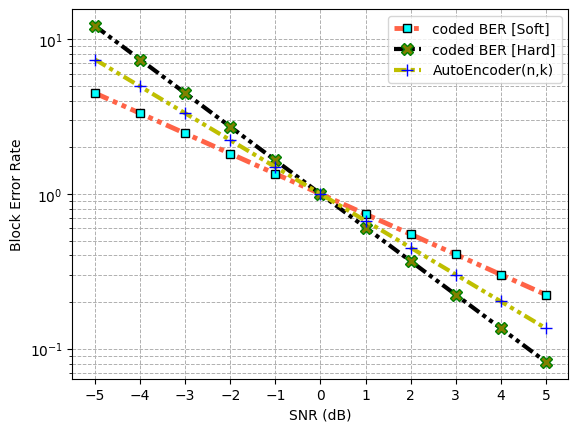

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example Data: Replace with actual data if available
snr_dB = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])  # SNR values from -5 to 5
codedBLERsoft = np.exp(-0.3 * snr_dB)  # Example data for coded BLER [Soft]
codedBLERhard = np.exp(-0.5 * snr_dB)  # Example data for coded BLER [Hard]
bler = np.exp(-0.4 * snr_dB)  # Example data for AutoEncoder BLER

# Create figure and axis
fig, ax = plt.subplots()

# Plotting coded BLER [Soft]
ax.semilogy(
    snr_dB, codedBLERsoft, 'tomato', lw=3.5,
    linestyle=(0, (3, 1, 1, 1, 1, 1)), marker="s", ms=6,
    mec="k", mfc="cyan", label="coded BER [Soft]"
)

# Plotting coded BLER [Hard]
ax.semilogy(
    snr_dB, codedBLERhard, 'k', lw=3,
    linestyle=(0, (3, 1, 1, 1, 1, 1)), marker="X", ms=9,
    mec="green", mfc="olive", label="coded BER [Hard]"
)

# Plotting AutoEncoder(n,k) BLER
ax.semilogy(
    snr_dB, bler, 'y', lw=3,
    linestyle=(0, (3, 1, 1, 1, 1, 1)), marker="+", ms=9,
    mec="blue", mfc="pink", label="AutoEncoder(n,k)"
)

# Adding legend, labels, and grid
ax.legend()
ax.set_xticks(snr_dB)  # Set x-ticks to match the SNR values
ax.grid(True, which='both', linestyle='--', linewidth=0.7)  # Grid for better visualization
ax.set_ylabel("Block Error Rate")
ax.set_xlabel("SNR (dB)")

# Display the plot
plt.show()


## Constellation Learning

The following cells provide the code to generate and plot the learned constellation by Tx in the presence of AWGN.


**Note:** we have to go back to the previous steps to change the values of `N`,`N_test` and `retrain the AE` to plot a constellation for `(7,4) AE` as it uses `TSNE`. For other cases such as (2,4) and (2,2) we can use same `N`,`N_test` for BLER and constellation plots.

In [ ]:
# #################################################################################
# # predicting the learned constellation for a given number of information symbols M
# #################################################################################
# constellationPoints = transmitter.predict(symbol_encodings)
# print("\n")
# print(constellationPoints)
# print("\n")
# print("Shape of learned constellation:" + str(constellationPoints.shape))

### learned constellation plot

1/1 [==============================] - 0s 31ms/step


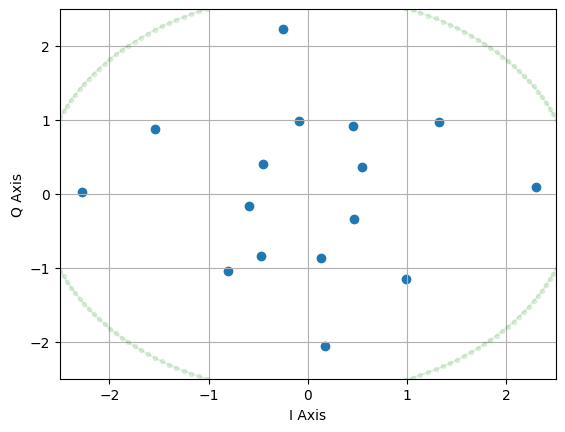

In [ ]:
###################################################################################
# plotting learned constellation under energy constraint for (n,k) = (2,4) or (2,2)
###################################################################################
constellationPoints = transmitter.predict(symbol_encodings)
r = np.linalg.norm(constellationPoints[0])
theta = np.linspace(0,2*np.pi,200)
fig, ax = plt.subplots()
ax.scatter(constellationPoints[:,0],constellationPoints[:,1])
ax.plot(r*np.cos(theta),r*np.sin(theta), c="green", alpha = 0.1, marker=".")
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

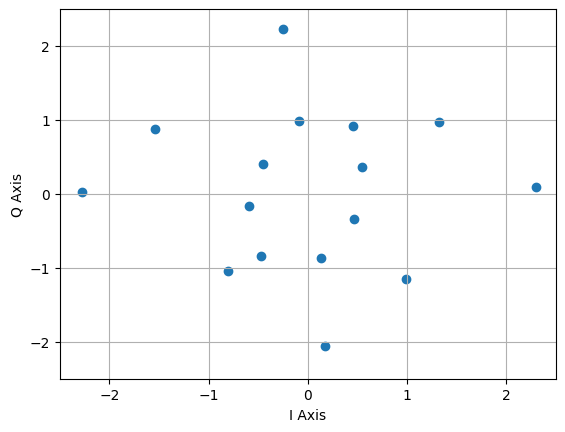

In [ ]:
##########################################################################################
# plotting learned constellation under average power constraint for (n,k) = (2,4) or (2,2)
##########################################################################################

fig, ax = plt.subplots()
ax.scatter(constellationPoints[:,0],constellationPoints[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

The following code snippet use TSNE to reduce the dimension of constellation for `(n,k) = (7,4)`

In [ ]:
# ###########################################################################################################
# # Using sklearn T-distributed Stochastic Neighbor Embedding (TSNE) to reduce the dimension of constellation
# ###########################################################################################################
# num_samples = N_test

# noise       = noise_stddev*np.random.randn(num_samples,n)
# X           = transmitter.predict(test_data)
# X_noisy     = X + noise

# X_embedded  = TSNE(n_components=2, learning_rate='auto', n_iter = 35000, random_state = 0, perplexity=60).fit_transform(X_noisy)
# X_embedded  = X_embedded/n

In [ ]:
# ####################################################################################
# # plotting higher dimensional received constellation in lower dimensions for (7,4) AE
# ####################################################################################
# fig, ax = plt.subplots()
# ax.scatter(X_embedded[:,0],X_embedded[:,1], marker = ".")
# plt.axis((-2,2,-2,2))
# plt.grid()
# plt.xlabel('I Axis')
# plt.ylabel('Q Axis')
# plt.show()

#### For (n,k) = (2,4) or (2,2) AutoEncoders


It turns out that under M = 16 and with an `energy constraint`, `(2,4) AE` learns a constellation which resemble `16-ary PSK` and with `power constraint` it learns a constellation which resemble `16-ary APSK`.

## References


[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on
Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.